In [1]:
import numpy as np

In [2]:
a = FID(5, "x", qubits = [1,2])
print(a)

NameError: name 'FID' is not defined

In [4]:
def FID(time, initial_phi = 0, measurment_basis = "x", qubits = [0,1,2,3,4]):
    # initial state
    qasm = "{"
    for q in qubits:
        if q == qubits[-1]:
            qasm += f'''Ry q[{q}], {3.14/2.}'''
        else:
            qasm += f'''Ry q[{q}], {3.14/2.} |'''
    qasm += "} \n"

    if initial_phi > 0:
        for q in qubits:
            if q == qubits[-1]:
                qasm += f'''Rz q[{q}], {initial_phi}'''
            else:
                qasm += f'''Rz q[{q}], {initial_phi} |'''
        qasm += "} \n"

    # waiting
    for q in qubits:
        qasm += f'''
        Wait q[{q}], {int(time)}'''  
    qasm += "\n {"
    
    
    # measurment
    for q in qubits:
        if q == qubits[-1]:
            qasm += f'''Measure_{measurment_basis} q[{q}]'''
        else:
            qasm += f'''Measure_{measurment_basis} q[{q}] | '''
    qasm += "} \n"    
    return qasm

# translate numbetr to binary
def translate_to_binary(number):
    return format(number, '05b')
def get_computational_basis(result):
    list_out = []
    for n in range(len(result['histogram'])):
        list_out.append([])
        for k in range(2**5):
            label = translate_to_binary(k)
            try:
                prob = result['histogram'][n][str(k)] 
            except:
                prob = 0
            list_out[-1].append((label, prob))
    return list_out


def get_expecitations(result):
    listout = get_computational_basis(result)
    probabilities = np.zeros((len(listout),2,5))
    for l,outcomes in enumerate(listout):
        for outcome in outcomes:
          
            res = np.array([int(x) for x in outcome[0]])
            for i in range(5):
                probabilities[l,res[i],i] += outcome[1]

    expectation_values = np.zeros((len(listout),5))
    for l in range(len(listout)):
        for i in range(5):
            expectation_values[l,i] = probabilities[l,0,i] - probabilities[l,-1,i]


    return expectation_values




In [5]:


from getpass import getpass
from coreapi.auth import BasicAuthentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI



#Connect to QI API, If no project has been initialized yet, uncomment the 3rd line to create one
server_url = r'https://api.quantum-inspire.com'
authentication = BasicAuthentication("j.a.krzywda@liacs.leidenuniv.nl","Rewolucja#93")
QI.set_authentication(authentication, project_name='python-test')
qi = QuantumInspireAPI(server_url, authentication, 'Qit')


backend_type = qi.get_backend_type_by_name('Starmon-5')

def send_circuit(circuit, shots):
    return qi.execute_qasm(circuit, backend_type=backend_type, number_of_shots=shots)

In [16]:

def batch(times, Nmax = 8, shots = 1024, qubits = [0,1,2,3,4], measure = ["x","y"]):
    intro = '''version 1.0
    qubits 5
    '''

    expect_values = np.zeros((3,5,len(times)))
    result_log = []
    circ = ""
    inds = []
    for nb,b in enumerate(measure):
        for tn,time in enumerate(times):
            circ += "{"
            for q in qubits:
                if q == qubits[-1]:
                    circ += f'''prep_z q[{q}]'''
                else:
                    circ += f'''prep_z q[{q}] |'''
            circ += "}\n"  
        
            circ += FID(time, measurment_basis = b, qubits = qubits)
            inds.append(tn)
            if len(inds) == Nmax or tn == len(times)-1:
                print(intro+circ)
                result = send_circuit(intro+circ, shots = shots)
                result_log.append(result)
                expect_values[nb,:,np.array(inds)] = get_expecitations(result)
                circ = ""
                inds = []

    return expect_values, result_log
            

In [59]:
times = np.linspace(0,500,31)
expect_values, result_log = batch(times, shots = 1024*8, qubits = [3], measure = ["x","y","z"])

version 1.0
    qubits 5
    {prep_z q[1] |prep_z q[3]}
{Ry q[1], 1.57 |Ry q[3], 1.57} 

        Wait q[1], 0
        Wait q[3], 0
 {Measure_x q[1] | Measure_x q[3]} 
{prep_z q[1] |prep_z q[3]}
{Ry q[1], 1.57 |Ry q[3], 1.57} 

        Wait q[1], 16
        Wait q[3], 16
 {Measure_x q[1] | Measure_x q[3]} 
{prep_z q[1] |prep_z q[3]}
{Ry q[1], 1.57 |Ry q[3], 1.57} 

        Wait q[1], 33
        Wait q[3], 33
 {Measure_x q[1] | Measure_x q[3]} 
{prep_z q[1] |prep_z q[3]}
{Ry q[1], 1.57 |Ry q[3], 1.57} 

        Wait q[1], 50
        Wait q[3], 50
 {Measure_x q[1] | Measure_x q[3]} 
{prep_z q[1] |prep_z q[3]}
{Ry q[1], 1.57 |Ry q[3], 1.57} 

        Wait q[1], 66
        Wait q[3], 66
 {Measure_x q[1] | Measure_x q[3]} 
{prep_z q[1] |prep_z q[3]}
{Ry q[1], 1.57 |Ry q[3], 1.57} 

        Wait q[1], 83
        Wait q[3], 83
 {Measure_x q[1] | Measure_x q[3]} 
{prep_z q[1] |prep_z q[3]}
{Ry q[1], 1.57 |Ry q[3], 1.57} 

        Wait q[1], 100
        Wait q[3], 100
 {Measure_x q[1] | Measure_

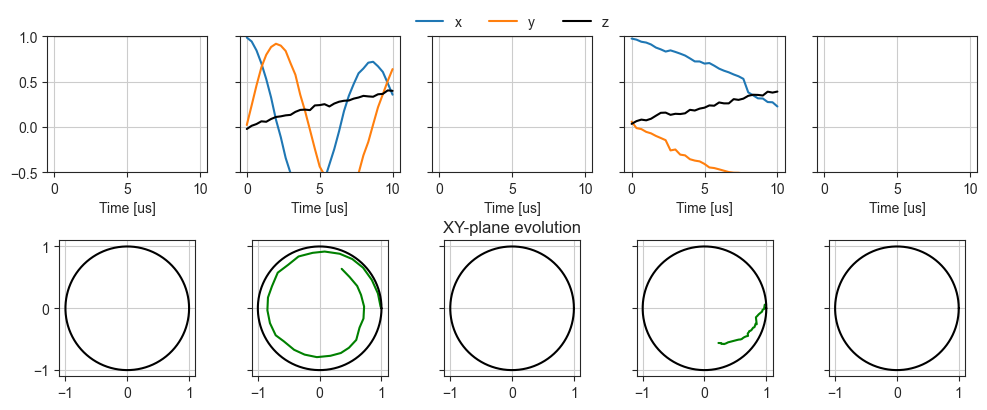

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

fig, ax = plt.subplots(2,5, figsize = (10,4))
plt.subplots_adjust(hspace = 0.5, left=0.05, right=0.98, top = 0.95, bottom = 0.1)
ax[1,2].set_title("XY-plane evolution")
for k in range(5):
    ax[0,k].grid(True)
    ax[1,k].grid(True)
    ax[0,k].plot(times*20/1e3,expect_values[0,k,:], label = "x")
    ax[0,k].plot(times*20/1e3,expect_values[1,k,:], label = "y")
    ax[0,k].plot(times*20/1e3,expect_values[2,k,:], c="k", label = "z")
    ax[0,k].set_xlabel("Time [us]")
    if k ==2:
        ax[0,k].legend(ncol=3, bbox_to_anchor=(0.5, 1.25), loc='upper center', frameon=False)

    if k>0:
        ax[0,k].set_yticklabels([])
        ax[1,k].set_yticklabels([])
    ax[1,k].set_yticks([-1,0,1])
    ax[0,k].set_ylim(-0.5,1)
    ax[1,k].plot(expect_values[0,k,:],expect_values[1,k,:], "g")
    ax[1,k].set_aspect('equal', 'box')
    #plot a circle
    theta = np.linspace(0, 2*np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    ax[1,k].plot(x, y, 'k')

plt.savefig("260624_1415_FIDx13.png",dpi=200)

In [31]:

#Create the qasm code for the Quantum Computer/Simulator
x_measure = '''version 1.0
qubits 5
'''
times = np.linspace(0, 32, 9)[1:]
for time in times:
    x_measure += FID(time, basis="x")
    x_measure += f'''
    {{prep_z q[0] | prep_z q[1] | prep_z q[2] | prep_z q[3] | prep_z q[4]}}'''


#Create the qasm code for the Quantum Computer/Simulator
y_measure = '''version 1.0
qubits 5
'''
times = np.linspace(0, 32, 9)[1:]
for time in times:
    y_measure += FID(time, basis = "y")
    y_measure += f'''
    {{prep_z q[0] | prep_z q[1] | prep_z q[2] | prep_z q[3] | prep_z q[4]}}'''




#Select the backend and make the run.
#The result contains lots of text and URL's, but we're interested in the result of the run.
# This  can be found in the 'histogram', ordered as: [OrderedDict({'1': 1.0})]
resultx = qi.execute_qasm(x_measure, backend_type=backend_type, number_of_shots=1024*8)
resulty = qi.execute_qasm(y_measure, backend_type=backend_type, number_of_shots=1024*8)

In [27]:
# translate numbetr to binary
def translate_to_binary(number):
    return format(number, '05b')
def get_computational_basis(result):
    list_out = []
    for n in range(len(result['histogram'])):
        list_out.append([])
        for k in range(2**5):
            label = translate_to_binary(k)
            try:
                prob = result['histogram'][n][str(k)] 
            except:
                prob = 0
            list_out[-1].append((label, prob))
    return list_out


def get_expecitations(result):
    listout = get_computational_basis(result)
    probabilities = np.zeros((len(listout),2,5))
    for l,outcomes in enumerate(listout):
        for outcome in outcomes:
          
            res = np.array([int(x) for x in outcome[0]])
            for i in range(5):
                probabilities[l,res[i],i] += outcome[1]

    expectation_values = np.zeros((len(listout),5))
    for l in range(len(listout)):
        for i in range(5):
            expectation_values[l,i] = probabilities[l,0,i] - probabilities[l,-1,i]


    return expectation_values

In [9]:
expectx = get_expecitations(resultx)
expecty = get_expecitations(resulty)

NameError: name 'resultx' is not defined